## BalanceNet prototype

In [4]:
%run Setup.ipynb
%run ExtraFunctions.ipynb

[i] Loaded Parameters:
 40000 35 0.2 200 
 dataset/glove/glove.twitter.27B.200d.txt
[i] Importing Modules...


Using TensorFlow backend.


[+] Using Keras version 2.2.4
[+] Finished Importing Modules
[i] Reading from csv file...Done!
[i] Found 34359 unique tokens.
[+] Shape of data tensor: (47288, 30)
[+] Shape of label tensor: (47288, 5)
[i] Number of entries in each category:
[+] Training:
 [ 7725. 13042. 12717.  3452.   895.]
[+] Validation:
 [1918. 3255. 3221.  849.  214.]
[i] Loading GloVe from: dataset/glove/glove.twitter.27B.200d.txt ...Done.
[+] Proceeding with Embedding Matrix...[i] Completed!
[i] Finished running setup.


In [5]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Completed!


In [6]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

Instructions for updating:
Colocations handled automatically by placer.


First Half: LSTM > CNN

In [7]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

Second Half: CNN > LSTM

In [9]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

Combine both halfs of the model

In [10]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

In [11]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=0.9, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [12]:
!rm -r logs

In [13]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [14]:
model.summary()
model.save('BalanceNet.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 12)       9936        embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectio

In [12]:
model = keras.models.load_model("checkpoint-0.91.h5")

OSError: Unable to open file (unable to open file: name = 'checkpoint-0.91.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Time to train!!

In [17]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=200, batch_size=128,
          callbacks=[tensorboard, model_checkpoints])


Training Progress:
Train on 37831 samples, validate on 9457 samples
Epoch 1/200
37831/37831 [==============================] - 123s 3ms/step - loss: 1.2557 - acc: 0.4250 - val_loss: 1.1330 - val_acc: 0.5125
Epoch 2/200
37831/37831 [==============================] - 124s 3ms/step - loss: 1.1117 - acc: 0.5269 - val_loss: 1.0660 - val_acc: 0.5642
Epoch 3/200
37831/37831 [==============================] - 126s 3ms/step - loss: 1.0457 - acc: 0.5619 - val_loss: 1.0096 - val_acc: 0.5833
Epoch 4/200
37831/37831 [==============================] - 120s 3ms/step - loss: 1.0126 - acc: 0.5787 - val_loss: 0.9850 - val_acc: 0.6021
Epoch 5/200
37831/37831 [==============================] - 108s 3ms/step - loss: 0.9885 - acc: 0.5909 - val_loss: 0.9683 - val_acc: 0.6140
Epoch 6/200
37831/37831 [==============================] - 111s 3ms/step - loss: 0.9718 - acc: 0.6013 - val_loss: 0.9519 - val_acc: 0.6183
Epoch 7/200
37831/37831 [==============================] - 117s 3ms/step - loss: 0.9582 - acc: 0.6

37831/37831 [==============================] - 125s 3ms/step - loss: 0.8530 - acc: 0.6541 - val_loss: 0.9081 - val_acc: 0.6328
Epoch 60/200
37831/37831 [==============================] - 123s 3ms/step - loss: 0.8508 - acc: 0.6558 - val_loss: 0.9111 - val_acc: 0.6302
Epoch 61/200
37831/37831 [==============================] - 125s 3ms/step - loss: 0.8539 - acc: 0.6541 - val_loss: 0.9103 - val_acc: 0.6301
Epoch 62/200
37831/37831 [==============================] - 125s 3ms/step - loss: 0.8494 - acc: 0.6563 - val_loss: 0.9110 - val_acc: 0.6297
Epoch 63/200
37831/37831 [==============================] - 125s 3ms/step - loss: 0.8498 - acc: 0.6521 - val_loss: 0.9106 - val_acc: 0.6305
Epoch 64/200
37831/37831 [==============================] - 125s 3ms/step - loss: 0.8493 - acc: 0.6563 - val_loss: 0.9087 - val_acc: 0.6298
Epoch 65/200
37831/37831 [==============================] - 125s 3ms/step - loss: 0.8475 - acc: 0.6562 - val_loss: 0.9097 - val_acc: 0.6282
Epoch 66/200
37831/37831 [=======

37831/37831 [==============================] - 126s 3ms/step - loss: 0.8222 - acc: 0.6685 - val_loss: 0.9139 - val_acc: 0.6274
Epoch 118/200
37831/37831 [==============================] - 125s 3ms/step - loss: 0.8244 - acc: 0.6675 - val_loss: 0.9140 - val_acc: 0.6277
Epoch 119/200
37831/37831 [==============================] - 126s 3ms/step - loss: 0.8219 - acc: 0.6685 - val_loss: 0.9135 - val_acc: 0.6303
Epoch 120/200
37831/37831 [==============================] - 125s 3ms/step - loss: 0.8228 - acc: 0.6686 - val_loss: 0.9136 - val_acc: 0.6290
Epoch 121/200
37831/37831 [==============================] - 126s 3ms/step - loss: 0.8218 - acc: 0.6701 - val_loss: 0.9137 - val_acc: 0.6282
Epoch 122/200
37831/37831 [==============================] - 126s 3ms/step - loss: 0.8172 - acc: 0.6694 - val_loss: 0.9147 - val_acc: 0.6286
Epoch 123/200
37831/37831 [==============================] - 126s 3ms/step - loss: 0.8196 - acc: 0.6692 - val_loss: 0.9145 - val_acc: 0.6285
Epoch 124/200
37831/37831 [

37831/37831 [==============================] - 125s 3ms/step - loss: 0.8034 - acc: 0.6776 - val_loss: 0.9179 - val_acc: 0.6275
Epoch 176/200
37831/37831 [==============================] - 125s 3ms/step - loss: 0.8064 - acc: 0.6784 - val_loss: 0.9177 - val_acc: 0.6286
Epoch 177/200
37831/37831 [==============================] - 125s 3ms/step - loss: 0.8020 - acc: 0.6779 - val_loss: 0.9179 - val_acc: 0.6286
Epoch 178/200
37831/37831 [==============================] - 125s 3ms/step - loss: 0.8051 - acc: 0.6761 - val_loss: 0.9187 - val_acc: 0.6285
Epoch 179/200
37831/37831 [==============================] - 125s 3ms/step - loss: 0.8047 - acc: 0.6758 - val_loss: 0.9195 - val_acc: 0.6281
Epoch 180/200
37831/37831 [==============================] - 125s 3ms/step - loss: 0.8039 - acc: 0.6782 - val_loss: 0.9198 - val_acc: 0.6277
Epoch 181/200
37831/37831 [==============================] - 125s 3ms/step - loss: 0.8034 - acc: 0.6772 - val_loss: 0.9190 - val_acc: 0.6276
Epoch 182/200
37831/37831 [

NameError: name 'pandas' is not defined

In [20]:
import pandas as pd
pd.DataFrame(model_log.history).to_csv("history-balance.csv")

## Model Testing and Inference

In [23]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["neutral", "happy", "sad", "hate","anger"]

In [24]:
! ls

BalanceNet-1.0.ipynb       checkpoint-0.925.h5
BalanceNet.h5              checkpoint-0.927.h5
ClassMerge.ipynb           checkpoint-0.930.h5
ExtraFunctions.ipynb       checkpoint-0.933.h5
Keras_CNN.ipynb            checkpoint-0.941.h5
Keras_CNN_Merge.ipynb      checkpoint-0.948.h5
Keras_LSTM-C-Merge.ipynb   checkpoint-0.952.h5
Keras_LSTM-C.ipynb         checkpoint-0.968.h5
Keras_LSTM-Inception.ipynb checkpoint-0.985.h5
Keras_LSTM.ipynb           checkpoint-1.010.h5
ProcessData-Crawled.ipynb  checkpoint-1.066.h5
ProcessData.ipynb          checkpoint-1.133.h5
README.md                  data.csv
Setup.ipynb                dataset
WideNet-1.0.ipynb          experiments
_config.yml                history-balance.csv
checkpoint-0.908.h5        images
checkpoint-0.909.h5        logs
checkpoint-0.910.h5        raw_data
checkpoint-0.911.h5        run_tensorboard.sh
checkpoint-0.914.h5        sklearn_experiments
checkpoint-0.917.h5        test_env.py
checkpoint-0.918.h5        tokenizer.pickle
c

In [38]:
#model_test = load_model('checkpoint-0.866.h5')
model_test = load_model('checkpoint-0.908.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model_test.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [39]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

     neutral       0.48      0.43      0.45      1918
       happy       0.66      0.71      0.68      3255
         sad       0.63      0.66      0.65      3221
        hate       0.81      0.66      0.73       849
       anger       0.90      0.69      0.78       214

   micro avg       0.63      0.63      0.63      9457
   macro avg       0.70      0.63      0.66      9457
weighted avg       0.63      0.63      0.63      9457



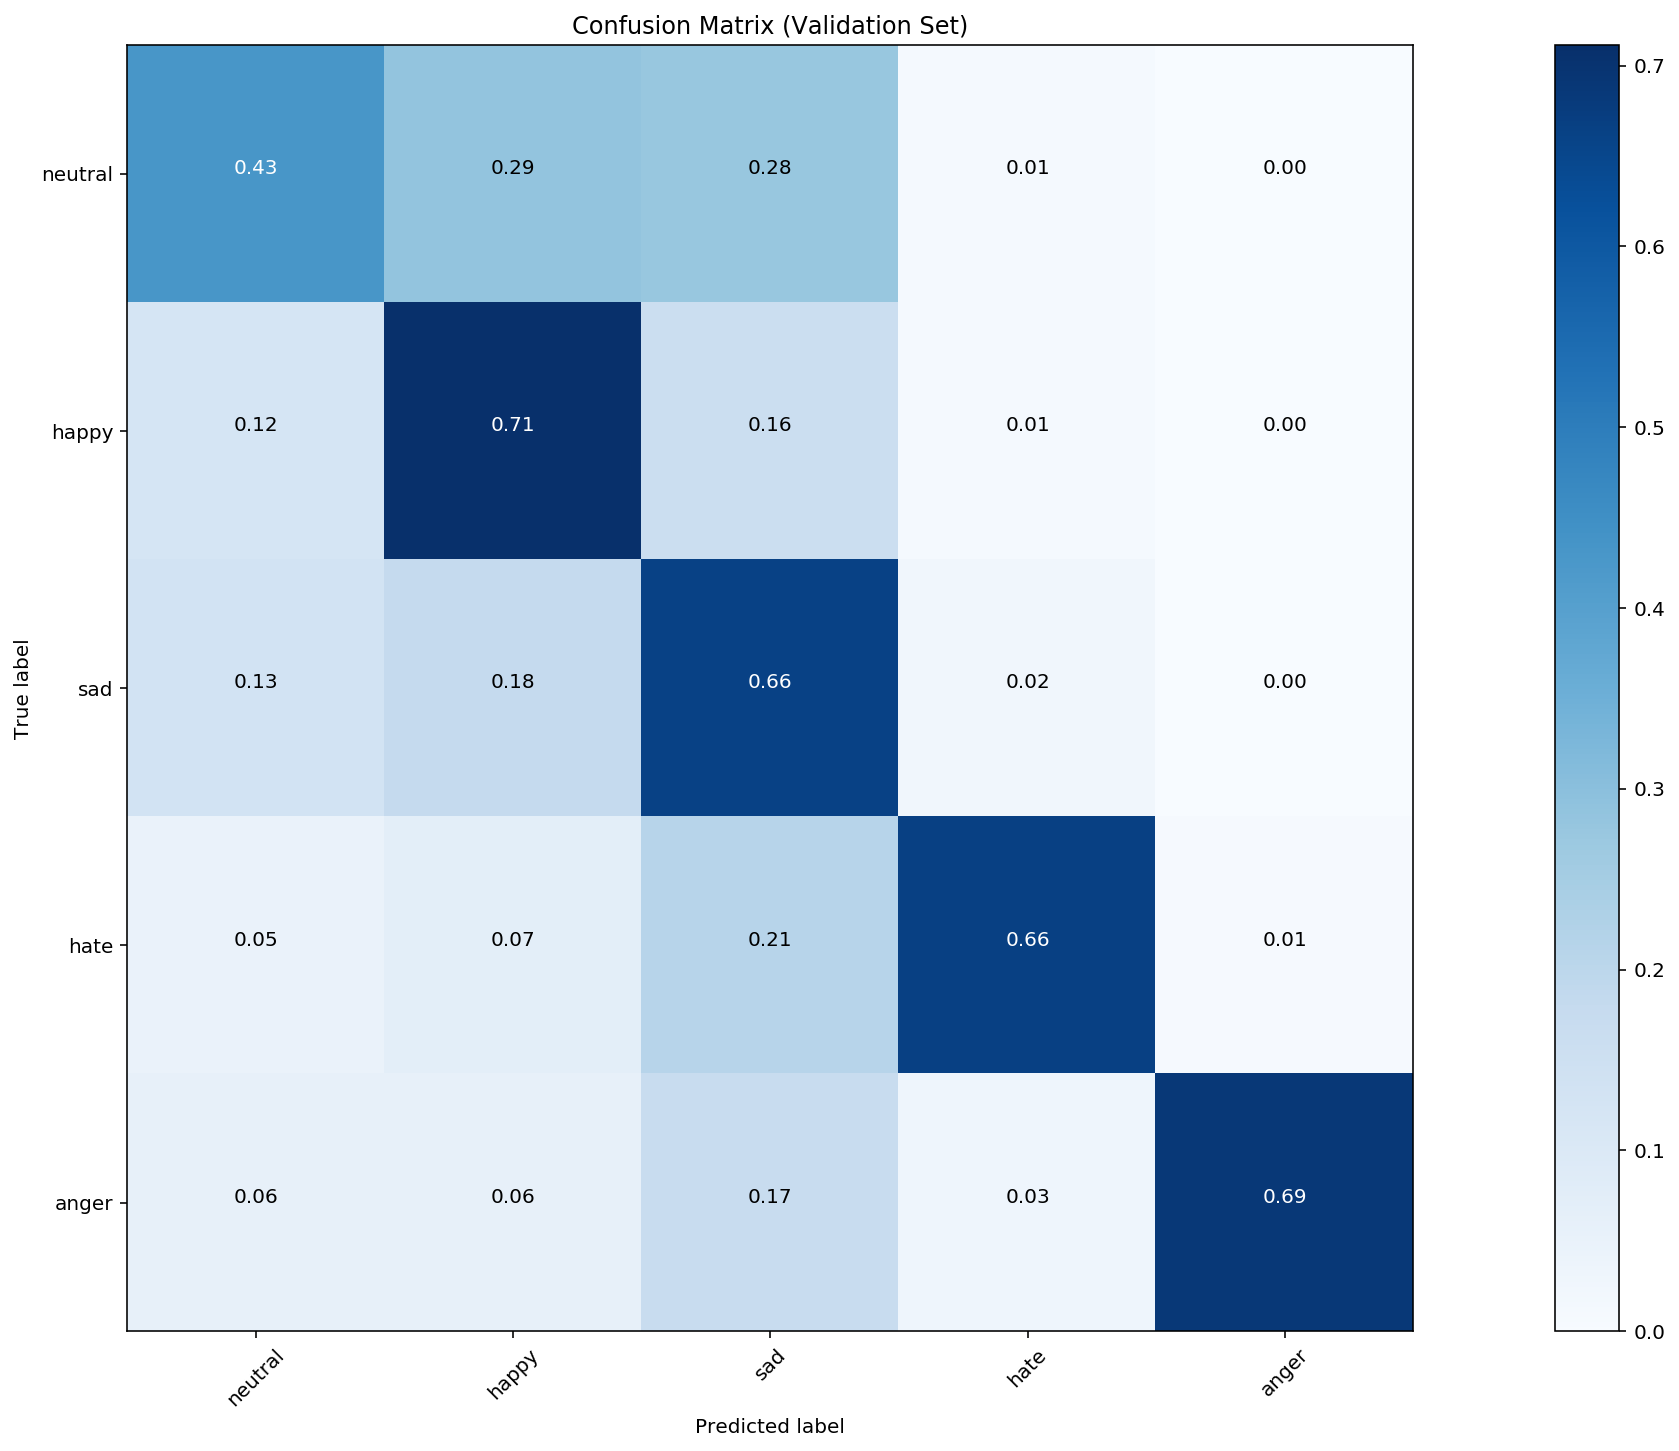

In [40]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)


In [58]:
text = ["I salute you for the bravery and sacrifice! A true hero indeed.",
        "Light travels faster than sound. This is why some people appear bright until they speak",
        "I feel so miserable without you, it’s almost like having you here.",
        "I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!?",
        
        "Sanyam loathes Aman",
        "Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism",
        "Somebody needs to water Tharman's head, hair needs to be grown there",
        "what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen?",
        "What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la"
       ]

In [59]:
sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPrediction:",classes[pred],"\n")

I salute you for the bravery and sacrifice! A true hero indeed. 
Prediction: happy 

Light travels faster than sound. This is why some people appear bright until they speak 
Prediction: neutral 

I feel so miserable without you, it’s almost like having you here. 
Prediction: sad 

I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!? 
Prediction: happy 

Sanyam loathes Aman 
Prediction: neutral 

Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism 
Prediction: sad 

Somebody needs to water Tharman's head, hair needs to be grown there 
Prediction: sad 

what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen? 
Prediction: neutral 

What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now 

In [43]:
np.array(sequences_test[0])

array([   1, 6097,    5,   12,    3,    6, 4841,    4,  515, 1476, 1238])